# Setup

In [179]:
import os
import csv
from collections import Counter
from itertools import chain
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import string
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np

# Data preprocessing

In [180]:
# Multi-artist dataset

path = '/content/drive/MyDrive/song_lyrics/csv'

songs = []
for artist in os.listdir(path):
    if (artist[-3:] == 'csv'):
        with open(os.path.join(path, artist), newline='') as csvfile:
            reader = csv.reader(csvfile)
            next(csvfile)
            for row in reader:
                songs.append(row[4])

for i in range(len(songs)):
    songs[i] = songs[i].lower().strip().split()

word_counts = Counter(chain(*songs))

sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
int2word = {index + 1: word for index, word in enumerate(sorted_vocab)}
word2int = {word: index for index, word in int2word.items()}

for i in range(len(songs)):
    songs[i] = [word2int[word] for word in songs[i]]

window_size=50
step=25
segmented_songs = []
for song in songs:
    for start in range(0, len(song) - window_size + 1, step):
        segmented_songs.append(song[start:start + window_size])

songs_tensors = [torch.tensor(song, dtype=torch.long) for song in songs]
songs_tensors = [torch.tensor(song, dtype=torch.long) for song in segmented_songs]
padded_songs = pad_sequence(songs_tensors, batch_first=True, padding_value=0)
print(padded_songs.shape)

torch.Size([3538, 50])


In [4]:
# Taylor Swift dataset
"""
path = '/content/drive/MyDrive/taylor_swift_genius_data.csv'

songs = []
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    next(csvfile)
    for row in reader:
        songs.append(row[3].translate(str.maketrans('', '', string.punctuation)))

for i in range(len(songs)):
    songs[i] = songs[i].lower().strip().split()

word_counts = Counter(chain(*songs))

sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
int2word = {index + 1: word for index, word in enumerate(sorted_vocab)}
word2int = {word: index for index, word in int2word.items()}

for i in range(len(songs)):
    songs[i] = [word2int[word] for word in songs[i]]

window_size=50
step=25
segmented_songs = []
for song in songs:
    for start in range(0, len(song) - window_size + 1, step):
        segmented_songs.append(song[start:start + window_size])

songs_tensors = [torch.tensor(song, dtype=torch.long) for song in songs]
songs_tensors = [torch.tensor(song, dtype=torch.long) for song in segmented_songs]
padded_songs = pad_sequence(songs_tensors, batch_first=True, padding_value=0)
print(padded_songs.shape)
"""

torch.Size([1955, 50])


# LSTM

In [181]:
class LyricsGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(LyricsGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output)
        output = self.fc(output)
        return output

In [182]:
def accuracy(preds, y):
    _, predictions = torch.max(preds, 1)
    correct = (predictions == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs):

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            pred = model(x)
            pred = pred.reshape(-1, pred.size(2))
            y = y.reshape(-1)
            loss = loss_fn(pred, y)
            acc = accuracy(pred, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_correct += acc.item() * y.size(0)
            total_train_samples += y.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / total_train_samples
        train_losses.append(avg_train_loss)
        train_accuracy.append(avg_train_acc)

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        total_val_loss = 0
        with torch.no_grad():
          for x, y in val_loader:
            x = x.cuda()
            y = y.cuda()
            pred = model(x)
            pred = pred.reshape(-1, pred.size(2))
            y = y.reshape(-1)
            loss = loss_fn(pred, y)
            acc = accuracy(pred, y)
            total_val_loss += loss.item()
            total_val_correct += acc.item() * y.size(0)
            total_val_samples += y.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_correct / total_val_samples
        val_losses.append(avg_val_loss)
        val_accuracy.append(avg_val_acc)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, '
              f'Training Accuracy: {avg_train_acc}, Validation Accuracy: {avg_val_acc}')

    torch.save(model.state_dict(), '/content/drive/My Drive/lstm.pth')

    return train_losses, val_losses, train_accuracy, val_accuracy

vocab_size = len(word2int) + 1
embedding_dim = 256
hidden_dim = 512
n_layers = 2

model = LyricsGenerator(vocab_size, embedding_dim, hidden_dim, n_layers)

if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 80
batch_size = 64
seq_length = 50

input_sequences = padded_songs[:, :-1]
target_sequences = padded_songs[:, 1:]

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    input_sequences, target_sequences, test_size=0.1, random_state=42
)

train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

train_losses, val_losses, train_accuracy, val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 1, Training Loss: 6.410480762014584, Validation Loss: 6.1125, Training Accuracy: 0.04496824169859328, Validation Accuracy: 0.048278060555458066
Epoch 2, Training Loss: 6.025861594141746, Validation Loss: 5.788490581512451, Training Accuracy: 0.0540920438967189, Validation Accuracy: 0.062372447550296785
Epoch 3, Training Loss: 5.6970217179278935, Validation Loss: 5.423157024383545, Training Accuracy: 0.07505986915559185, Validation Accuracy: 0.09929846823215485
Epoch 4, Training Loss: 5.392785091789401, Validation Loss: 5.156255626678467, Training Accuracy: 0.09689321931527585, Validation Accuracy: 0.12570152878761293
Epoch 5, Training Loss: 5.112858957173873, Validation Loss: 4.899666023254395, Training Accuracy: 0.11864847674661753, Validation Accuracy: 0.14910714328289032
Epoch 6, Training Loss: 4.803618051567856, Validation Loss: 4.623057842254639, Training Accuracy: 0.14370965060530877, Validation Accuracy: 0.18252550661563874
Epoch 7, Training Loss: 4.492177379374602, Valida

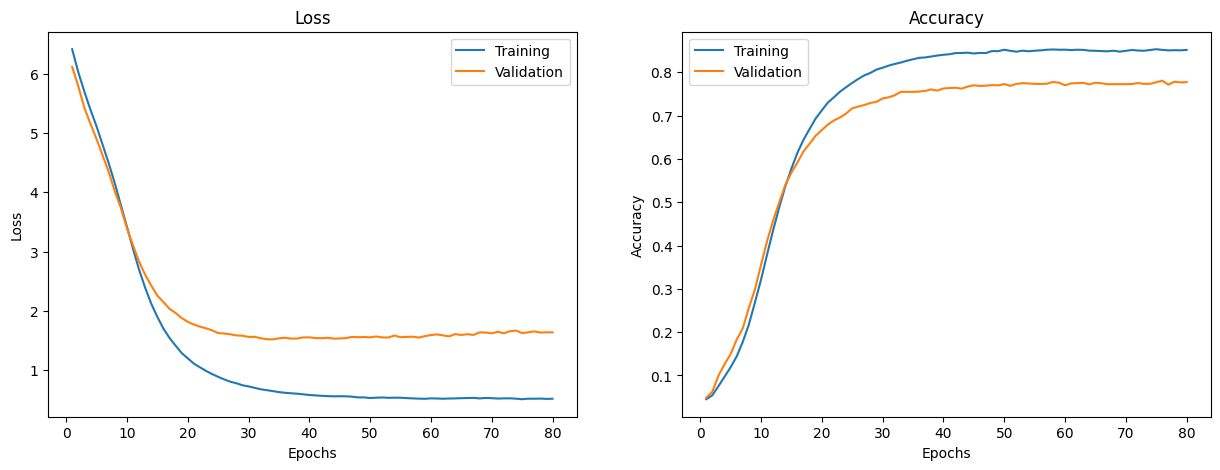

In [183]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training')
plt.plot(range(1, epochs+1), val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracy, label='Training')
plt.plot(range(1, epochs+1), val_accuracy, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# GAN

In [184]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output)
        output = self.fc(output)
        return output

class Discriminator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        output = self.sigmoid(output)
        return output

In [186]:
vocab_size = len(word2int) + 1
embedding_dim = 256
hidden_dim = 512
batch_size = 16
seq_length = 50
seed_length = 10
num_epochs = 50
n_layers = 2

generator = Generator(vocab_size, embedding_dim, hidden_dim, n_layers).cuda()
generator.train()

discriminator = Discriminator(vocab_size, embedding_dim, hidden_dim).cuda()

g_optimizer = optim.Adam(generator.parameters(), lr=0.01)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
criterion = nn.BCELoss()

window_size=10
step=10
segmented_songs = []
for i in range(20):
    for start in range(0, len(songs[i]) - window_size + 1, step):
        segmented_songs.append(songs[i][start:start + window_size])

songs_tensors = [torch.tensor(song, dtype=torch.long) for song in segmented_songs]
padded_seeds = pad_sequence(songs_tensors, batch_first=True, padding_value=0)

seed_loader = DataLoader(TensorDataset(padded_seeds), batch_size=batch_size, shuffle=True, drop_last=True)
data_loader = DataLoader(TensorDataset(padded_songs), batch_size=batch_size, shuffle=True, drop_last=True)

d_accuracies = []
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    total_g_loss = 0
    total_d_loss = 0
    real_label_scores = []
    fake_label_scores = []

    for batch in seed_loader:

        seed_sequences = batch[0].cuda()
        generator.eval()

        with torch.no_grad():
            generated_sequences = seed_sequences

            for _ in range(seq_length - seed_length):
                output = generator(generated_sequences)
                probabilities = torch.softmax(output[:, -1, :], dim=-1)
                next_word_idx = torch.multinomial(probabilities, num_samples=1)
                generated_sequences = torch.cat((generated_sequences, next_word_idx), dim=1)

        pred = discriminator(generated_sequences)
        rewards = pred.detach()
        g_optimizer.zero_grad()

        generator.train()
        discriminator.train()

        policy_loss = 0

        # Iterate through each step of the sequence
        for i in range(seq_length):
            current_logits = generator(generated_sequences[:, :i+1])
            log_probs = F.log_softmax(current_logits[:, -1, :], dim=-1)
            actual_tokens = generated_sequences[:, i]
            actual_log_probs = log_probs.gather(1, actual_tokens[:, None]).squeeze()
            step_rewards = rewards.squeeze(-1)
            policy_loss += (actual_log_probs * step_rewards).mean()

    policy_loss = -policy_loss
    total_g_loss += policy_loss.item()
    policy_loss.backward()

    g_optimizer.step()

    real_sequences = next(iter(data_loader))[0].cuda()
    fake_sequences = generated_sequences.detach()

    real_pred = discriminator(real_sequences)
    real_loss = criterion(real_pred, torch.ones_like(real_pred))

    fake_pred = discriminator(fake_sequences)
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    d_optimizer.step()

    total_d_loss += d_loss.item()

    # Calculate accuracy
    real_labels = torch.ones_like(real_pred)
    fake_labels = torch.zeros_like(fake_pred)
    combined_preds = torch.cat([real_pred, fake_pred])
    combined_labels = torch.cat([real_labels, fake_labels])

    predicted_labels = (combined_preds > 0.5).float()
    acc = accuracy_score(combined_labels.cpu().numpy(), predicted_labels.cpu().numpy())

    real_label_scores.extend(real_pred.detach().cpu().numpy())
    fake_label_scores.extend(fake_pred.detach().cpu().numpy())

    d_accuracies.append(acc)
    d_losses.append(total_d_loss)
    g_losses.append(total_g_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {total_g_loss:.4f}, "
          f"Discriminator Loss: {total_d_loss:.4f}, Discriminator Acc: {acc:.4f}")

torch.save(generator.state_dict(), '/content/drive/My Drive/gan.pth')

Epoch [1/50], Generator Loss: 209.5363, Discriminator Loss: 0.7027, Discriminator Acc: 0.4375
Epoch [2/50], Generator Loss: 201.2832, Discriminator Loss: 0.6617, Discriminator Acc: 0.8438
Epoch [3/50], Generator Loss: 184.5037, Discriminator Loss: 0.6475, Discriminator Acc: 0.7500
Epoch [4/50], Generator Loss: 98.8115, Discriminator Loss: 0.7742, Discriminator Acc: 0.4375
Epoch [5/50], Generator Loss: 182.5068, Discriminator Loss: 0.6622, Discriminator Acc: 0.6875
Epoch [6/50], Generator Loss: 185.1476, Discriminator Loss: 0.6259, Discriminator Acc: 0.5625
Epoch [7/50], Generator Loss: 182.0540, Discriminator Loss: 0.5886, Discriminator Acc: 0.7812
Epoch [8/50], Generator Loss: 114.5292, Discriminator Loss: 1.3906, Discriminator Acc: 0.5625
Epoch [9/50], Generator Loss: 123.5087, Discriminator Loss: 0.8934, Discriminator Acc: 0.5625
Epoch [10/50], Generator Loss: 95.4320, Discriminator Loss: 0.7193, Discriminator Acc: 0.7188
Epoch [11/50], Generator Loss: 115.6319, Discriminator Loss: 

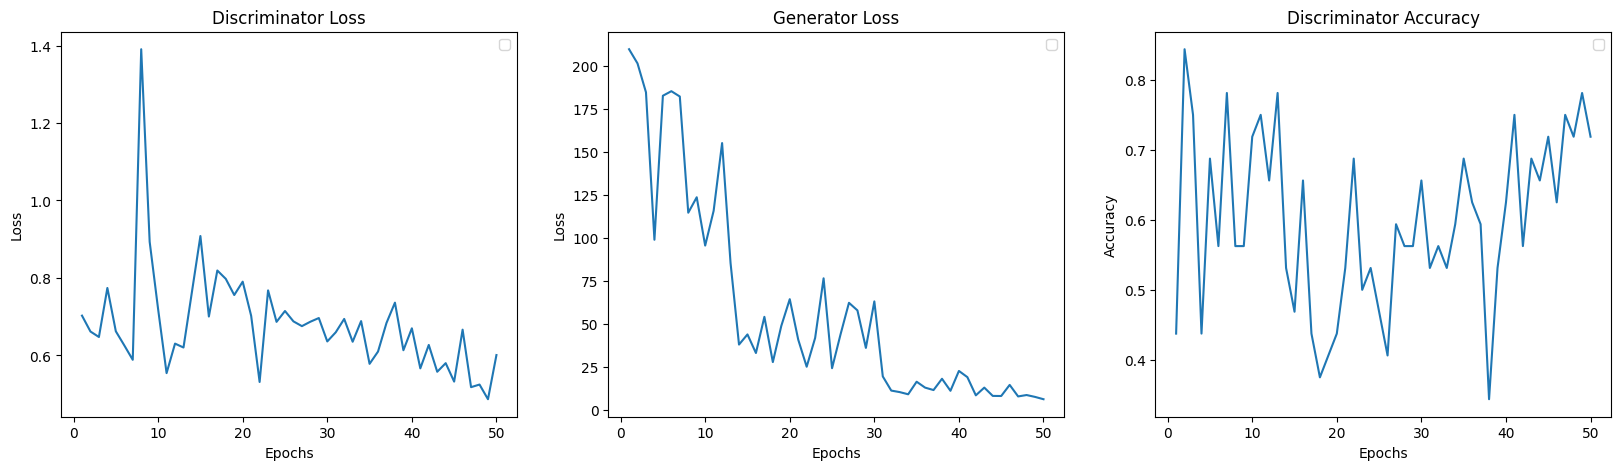

In [187]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), d_losses)
plt.title('Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), g_losses)
plt.title('Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), d_accuracies)
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# LSTM + GAN

In [188]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output)
        output = self.fc(output)
        return output

class Discriminator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        output = self.sigmoid(output)
        return output

In [189]:
vocab_size = len(word2int) + 1
embedding_dim = 256
hidden_dim = 512
batch_size = 16
seq_length = 50
seed_length = 10
num_epochs = 50
n_layers = 2

generator = Generator(vocab_size, embedding_dim, hidden_dim, n_layers).cuda()
generator.load_state_dict(torch.load('/content/drive/My Drive/lstm.pth'))
generator.train()

discriminator = Discriminator(vocab_size, embedding_dim, hidden_dim).cuda()

g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)
criterion = nn.BCELoss()

window_size=10
step=10
segmented_songs = []
for i in range(20):
    for start in range(0, len(songs[i]) - window_size + 1, step):
        segmented_songs.append(songs[i][start:start + window_size])

songs_tensors = [torch.tensor(song, dtype=torch.long) for song in segmented_songs]
padded_seeds = pad_sequence(songs_tensors, batch_first=True, padding_value=0)

seed_loader = DataLoader(TensorDataset(padded_seeds), batch_size=batch_size, shuffle=True, drop_last=True)
data_loader = DataLoader(TensorDataset(padded_songs), batch_size=batch_size, shuffle=True, drop_last=True)

d_accuracies = []
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    total_g_loss = 0
    total_d_loss = 0
    real_label_scores = []
    fake_label_scores = []

    for batch in seed_loader:

        seed_sequences = batch[0].cuda()
        generator.eval()

        with torch.no_grad():
            generated_sequences = seed_sequences

            for _ in range(seq_length - seed_length):
                output = generator(generated_sequences)
                probabilities = torch.softmax(output[:, -1, :], dim=-1)
                next_word_idx = torch.multinomial(probabilities, num_samples=1)
                generated_sequences = torch.cat((generated_sequences, next_word_idx), dim=1)

        pred = discriminator(generated_sequences)
        rewards = pred.detach()
        g_optimizer.zero_grad()

        generator.train()
        discriminator.train()

        policy_loss = 0

        # Iterate through each step of the sequence
        for i in range(seq_length):
            current_logits = generator(generated_sequences[:, :i+1])
            log_probs = F.log_softmax(current_logits[:, -1, :], dim=-1)
            actual_tokens = generated_sequences[:, i]
            actual_log_probs = log_probs.gather(1, actual_tokens[:, None]).squeeze()
            step_rewards = rewards.squeeze(-1)
            policy_loss += (actual_log_probs * step_rewards).mean()

    policy_loss = -policy_loss
    total_g_loss += policy_loss.item()
    policy_loss.backward()

    g_optimizer.step()

    real_sequences = next(iter(data_loader))[0].cuda()
    fake_sequences = generated_sequences.detach()

    real_pred = discriminator(real_sequences)
    real_loss = criterion(real_pred, torch.ones_like(real_pred))

    fake_pred = discriminator(fake_sequences)
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    d_optimizer.step()

    total_d_loss += d_loss.item()

    # Calculate accuracy
    real_labels = torch.ones_like(real_pred)
    fake_labels = torch.zeros_like(fake_pred)
    combined_preds = torch.cat([real_pred, fake_pred])
    combined_labels = torch.cat([real_labels, fake_labels])

    predicted_labels = (combined_preds > 0.5).float()
    acc = accuracy_score(combined_labels.cpu().numpy(), predicted_labels.cpu().numpy())

    real_label_scores.extend(real_pred.detach().cpu().numpy())
    fake_label_scores.extend(fake_pred.detach().cpu().numpy())

    d_accuracies.append(acc)
    d_losses.append(total_d_loss)
    g_losses.append(total_g_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {total_g_loss:.4f}, "
          f"Discriminator Loss: {total_d_loss:.4f}, Discriminator Acc: {acc:.4f}")

torch.save(generator.state_dict(), '/content/drive/My Drive/gan_with_lstm.pth')

Epoch [1/50], Generator Loss: 542.2534, Discriminator Loss: 0.6824, Discriminator Acc: 0.6562
Epoch [2/50], Generator Loss: 526.2994, Discriminator Loss: 0.6952, Discriminator Acc: 0.5000
Epoch [3/50], Generator Loss: 502.1319, Discriminator Loss: 0.6920, Discriminator Acc: 0.5625
Epoch [4/50], Generator Loss: 479.0237, Discriminator Loss: 0.6909, Discriminator Acc: 0.4688
Epoch [5/50], Generator Loss: 454.5030, Discriminator Loss: 0.7001, Discriminator Acc: 0.3750
Epoch [6/50], Generator Loss: 443.5804, Discriminator Loss: 0.6895, Discriminator Acc: 0.5312
Epoch [7/50], Generator Loss: 461.6146, Discriminator Loss: 0.6979, Discriminator Acc: 0.4062
Epoch [8/50], Generator Loss: 459.2346, Discriminator Loss: 0.6984, Discriminator Acc: 0.4062
Epoch [9/50], Generator Loss: 427.0134, Discriminator Loss: 0.6913, Discriminator Acc: 0.5938
Epoch [10/50], Generator Loss: 406.4538, Discriminator Loss: 0.7060, Discriminator Acc: 0.4375
Epoch [11/50], Generator Loss: 389.1217, Discriminator Loss

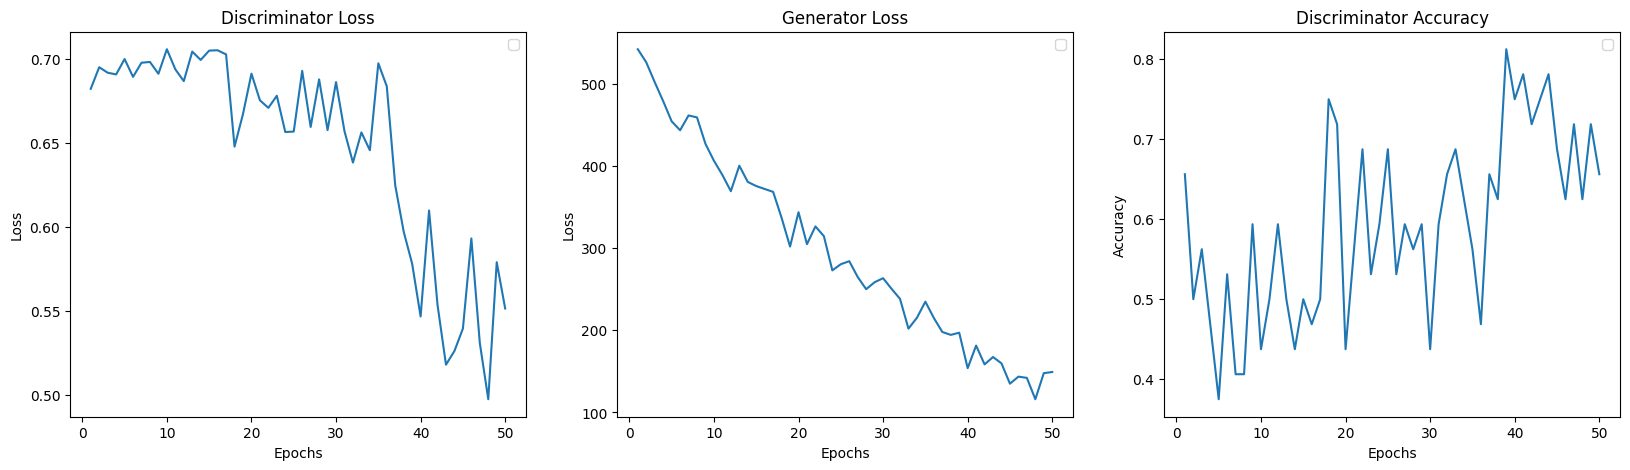

In [190]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), d_losses)
plt.title('Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), g_losses)
plt.title('Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), d_accuracies)
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Testing

In [ ]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.dropout(output)
        output = self.fc(output)
        return output

vocab_size = len(word2int) + 1
embedding_dim = 256
hidden_dim = 512
n_layers = 2
generator = Generator(vocab_size, embedding_dim, hidden_dim, n_layers).cuda()

seq_length = 100

def test(model, seed):
    words = seed.lower().strip().split()
    indices = [word2int[word] for word in words]
    input_tensor = torch.tensor([indices], dtype=torch.long).cuda()

    generated_sequence = input_tensor

    with torch.no_grad():
        for _ in range(seq_length - len(indices)):
            output = generator(generated_sequence)
            probabilities = torch.softmax(output[:, -1, :], dim=-1)
            next_word_idx = torch.multinomial(probabilities, num_samples=1)
            generated_sequence = torch.cat((generated_sequence, next_word_idx), dim=1)

    generated_words = [int2word[idx] for idx in generated_sequence.cpu()[0].numpy()]
    generated_text = ' '.join(generated_words)

    return generated_text

In [224]:
text = "once upon a time we were"

lstm_output = test(generator.load_state_dict(torch.load('/content/drive/My Drive/lstm.pth')), text) # LSTM
gan_output = test(generator.load_state_dict(torch.load('/content/drive/My Drive/gan.pth')), text) # GAN
gan_with_lstm_output = test(generator.load_state_dict(torch.load('/content/drive/My Drive/gan_with_lstm.pth')), text) # LSTM + GAN

print(f"LSTM Output: {lstm_output}")
print(f"GAN Output: {gan_output}")
print(f"GAN with LSTM Output: {gan_with_lstm_output}")

LSTM Output: once upon a time we were in way where we're going but the darkness give it to me one one one more time oh baby real you know to love you i got you through you about you you and only you i know that you got me fallin' so hard just a dream that it might love it when we talking sky pre is he did your touch it's all day i come in your eyes and i lose him m hey ah just let me looooooolove you you tunechi mula baby just let me looooooolove you you tunechi
GAN Output: once upon a time we were think of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of
GAN with LSTM Output: once upon a time we were not clings than will encountered who are town oohooh kinda lose control tears dumb oh tonight cookin' like lemon living in free used to healthy had done are drill s